In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/CourseMaterial/Supervised Machine Learning/Variational Autoencoder

/content/drive/MyDrive/CourseMaterial/Supervised Machine Learning/Variational Autoencoder


In [ ]:
data = pd.read_csv('mnist_train.csv')

In [ ]:
data = np.array(data)
data = data[0:10000,:] # Extracting first 10000 samples
data.shape

(10000, 785)

In [ ]:
# Data without labels because Unsupervised learning
data = data[:,1:]

# Data Normalization
dataN = data / np.max(data)

# Converting to pytorch tensor
dataT = torch.tensor( dataN, dtype = torch.float32)

In [ ]:
dataT.shape

torch.Size([10000, 784])

In [ ]:
dataT = dataT.reshape(dataT.shape[0], 1, 28, 28)

In [ ]:
dataT.shape

torch.Size([10000, 1, 28, 28])

# Create Variational Autoencoder Class

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE,self).__init__()

        # Encoder Layers

        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.linear1 = nn.Linear(512,300)
        self.mu = nn.Linear(300, 16) # latent_size = 16
        self.logvar = nn.Linear(300, 16)



        # Decoder Layers

        self.linear2 = nn.Linear(16, 300)
        self.linear3 = nn.Linear(300, 512)
        self.conv3 = nn.ConvTranspose2d(32, 16, kernel_size=5,stride=2)
        self.conv4 = nn.ConvTranspose2d(16, 1, kernel_size=5, stride=2)
        self.conv5 = nn.ConvTranspose2d(1, 1, kernel_size=4)



    def encoder(self,x):
        t = F.relu(self.conv1(x))
        t = F.relu(self.conv2(t))
        t = t.reshape((x.shape[0], -1))

        t = F.relu(self.linear1(t))
        mu = self.mu(t)
        logvar = self.logvar(t)
        return mu, logvar

    def reparameterization(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std).to(device)
        return eps*std + mu

    def unFlatten(self, x):
        return x.reshape((x.shape[0], 32, 4, 4))

    def decoder(self, z):
        t = F.relu(self.linear2(z))
        t = F.relu(self.linear3(t))
        t = self.unFlatten(t)
        t = F.relu(self.conv3(t))
        t = F.relu(self.conv4(t))
        t = torch.sigmoid(self.conv5(t))
        return t


    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterization(mu,logvar)
        pred = self.decoder(z)
        return pred, mu, logvar

# Create a loss function

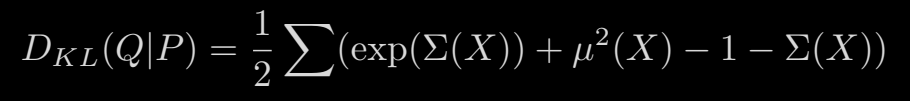

In [ ]:
def loss_func(reconstructed_image, original_image, mu, logvar):
    BCE = F.binary_cross_entropy(reconstructed_image, original_image, reduction = 'sum') # BCE Loss for image reconstruction
    DKL = -0.5 * torch.sum(-logvar.exp() - mu.pow(2) + 1 + logvar) # kld loss for reduccing similarities b/w distributions.
    return BCE + DKL # sum of all the losses


# We are using BCE loss since our target or original image is normalized between 0 and 1.
# reduction = 'sum' means we want to sum the output loss.

# Check GPU

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Create Model Instance and set optimizer

In [ ]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

In [ ]:
model

VAE(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (linear1): Linear(in_features=512, out_features=300, bias=True)
  (mu): Linear(in_features=300, out_features=16, bias=True)
  (logvar): Linear(in_features=300, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=512, bias=True)
  (conv3): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(2, 2))
  (conv4): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(2, 2))
  (conv5): ConvTranspose2d(1, 1, kernel_size=(4, 4), stride=(1, 1))
)

# Train the model

In [ ]:
epochs = 21001

losses = torch.zeros(epochs)

for epoch in range(epochs):

  # Selecting a batchsize  of 32.

  random_idx = np.random.choice(dataT.shape[0], size=32)

  X = dataT[random_idx,:].to(device)
  predicted, mu, logvar = model(X)
  loss = loss_func(predicted, X, mu, logvar)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  losses[epoch] = loss.item()

  if (epoch % 1000) == 0:

      print(f' epochs : {epoch}  loss : {loss : 2.2f}')

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


 epochs : 0  loss :  17797.74
 epochs : 1000  loss :  4957.33
 epochs : 2000  loss :  4118.67
 epochs : 3000  loss :  3844.76
 epochs : 4000  loss :  3998.88
 epochs : 5000  loss :  3709.99
 epochs : 6000  loss :  3817.15
 epochs : 7000  loss :  3645.65
 epochs : 8000  loss :  3440.34
 epochs : 9000  loss :  3463.15
 epochs : 10000  loss :  3192.98
 epochs : 11000  loss :  3637.48
 epochs : 12000  loss :  3496.22
 epochs : 13000  loss :  3642.35
 epochs : 14000  loss :  3668.61
 epochs : 15000  loss :  3190.94
 epochs : 16000  loss :  3283.85
 epochs : 17000  loss :  3511.74
 epochs : 18000  loss :  3346.01
 epochs : 19000  loss :  3789.71
 epochs : 20000  loss :  3377.09
 epochs : 21000  loss :  3381.35


# Performance Visualization

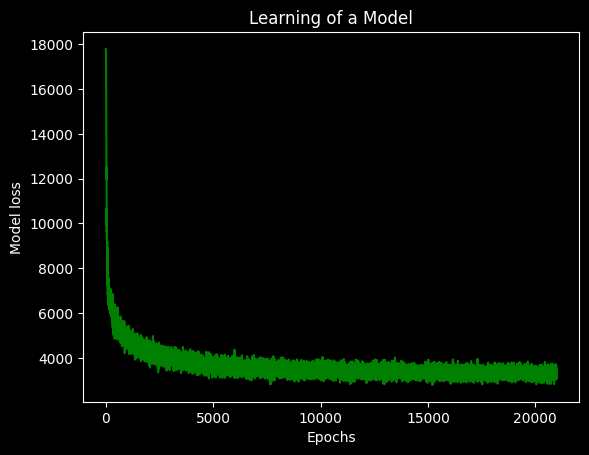

In [ ]:
plt.plot(losses, color = 'g', ls = '-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.title('Learning of a Model')
plt.show()

# Model Testing

In [ ]:
X = dataT[:7,:].to(device)  # Extracting first seven samples
ypred, mu, logvar = model(X)

In [ ]:
ypred.shape

torch.Size([7, 1, 28, 28])

# Visualizing Model Performance

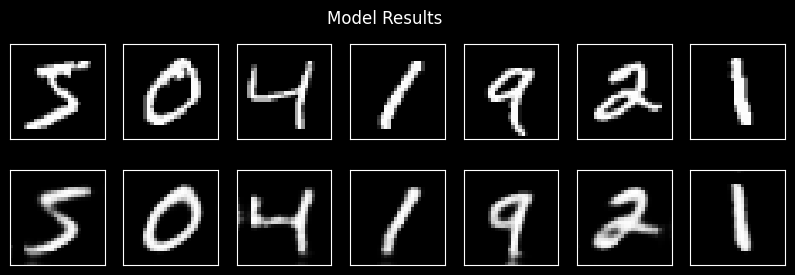

In [ ]:
fig,axes = plt.subplots(2,7,figsize=(10,3))

for i in range(7):
  axes[0,i].imshow(X[i,:].view(28,28).detach().cpu() ,cmap='gray')
  axes[1,i].imshow(ypred[i,:].view(28,28).detach().cpu() ,cmap='gray')
  axes[0,i].set_xticks([]), axes[0,i].set_yticks([])
  axes[1,i].set_xticks([]), axes[1,i].set_yticks([])

plt.suptitle('Model Results')
plt.show()

# Generating 7 samples from Gaussian Distribution of size equal to latent layer size i.e 16

In [ ]:
sample = torch.randn(7,16)

# Pass the samples to decoder

In [ ]:
y_pred = model.decoder(sample.to(device))

# Visualize the decoder performance on randomly generated samples

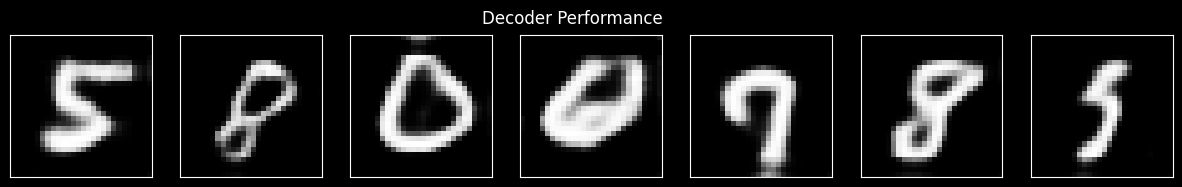

In [ ]:
fig,axes = plt.subplots(1,7,figsize=(15,2))

for i in range(7):
  axes[i].imshow(y_pred[i,:].view(28,28).detach().cpu() ,cmap='gray')
  axes[i].set_xticks([]), axes[i].set_yticks([])
  axes[i].set_xticks([]), axes[i].set_yticks([])

plt.suptitle('Decoder Performance')
plt.show()